✅ Loaded AnnData: 800 cells × 36753 genes


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Results saved to /sharedFolder/scanpy_clusters_umap.csv


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


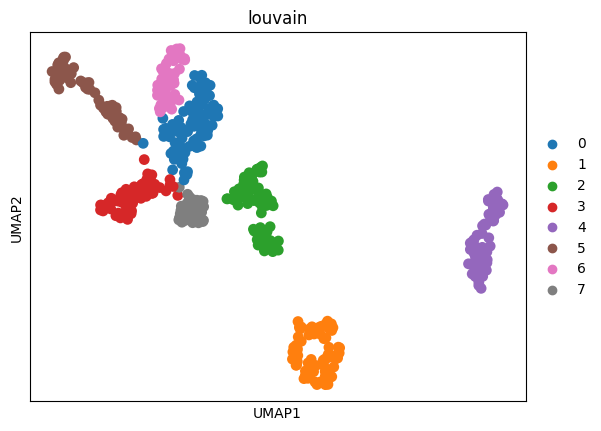

In [1]:
import scanpy as sc
import pandas as pd
from scipy import io
from scipy.sparse import csr_matrix
import numpy as np

# === Manual loading of Matrix Market format ===
mtx_path = "/sharedFolder/Data/"

# Load sparse matrix (transpose so cells are rows)
X = io.mmread(f"{mtx_path}/matrix.mtx.gz").T.tocsr()

# Load features (genes) and barcodes (cells)
genes = pd.read_csv(f"{mtx_path}/features.tsv.gz", header=None, sep="\t")
barcodes = pd.read_csv(f"{mtx_path}/barcodes.tsv.gz", header=None)

# Create AnnData object manually
adata = sc.AnnData(X)
adata.var_names = genes[0].astype(str)
adata.obs_names = barcodes[0].astype(str)

print(f"✅ Loaded AnnData: {adata.shape[0]} cells × {adata.shape[1]} genes")

# === Subsample 500 cells
np.random.seed(42)
selected_cells = np.random.choice(adata.n_obs, size=500, replace=False)
adata = adata[selected_cells, :]

# === Preprocessing ===
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Select top 1000 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var.highly_variable]

# Standard pipeline
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata, resolution=0.5)
sc.tl.umap(adata)

# === Save results
df = adata.obs.copy()
df[['UMAP_1', 'UMAP_2']] = adata.obsm['X_umap']
df.to_csv("/sharedFolder/scanpy_clusters_umap.csv")
print("✅ Results saved to /sharedFolder/scanpy_clusters_umap.csv")

# === Optional: plot UMAP
sc.pl.umap(adata, color=["louvain"], save="_louvain.png")
